In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df1 = pd.read_csv('Datasets/Code_Violations.csv')
df2 = pd.read_csv('Datasets/Code_Violations-1.csv')
code_violations = pd.concat([df1, df2], ignore_index=True)
print(code_violations.shape)

(98420, 24)


<font size =6>Step 1. Data cleaning and transformation</font>

<font size =4># 1. Glimpse the dataset

In [3]:
code_violations.dtypes
# Many of these columns are chracters

X                      float64
Y                      float64
violation_number        object
complaint_address       object
complaint_zip            int64
SBL                     object
violation               object
violation_date          object
comply_by_date          object
status_type_name        object
complaint_number        object
complaint_type_name     object
open_date               object
owner_name              object
inspector_id             int64
Neighborhood            object
Vacant                  object
owner_address           object
owner_city              object
owner_state             object
owner_zip_code          object
Latitude               float64
Longitude              float64
ObjectId                 int64
dtype: object

In [4]:
code_violations.head()

,X,Y,violation_number,complaint_address,complaint_zip,SBL,violation,violation_date,comply_by_date,status_type_name,...,inspector_id,Neighborhood,Vacant,owner_address,owner_city,owner_state,owner_zip_code,Latitude,Longitude,ObjectId
0,-8.480408e+06,5.317057e+06,2021-14216,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2021/08/27 14:20:05.683+00,2021/09/03 14:20:05+00,Closed,...,247,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,18
1,-8.480408e+06,5.317057e+06,2021-07690,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2021/05/20 15:28:46.050+00,2021/05/27 15:28:46+00,Closed,...,247,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,20
2,-8.480408e+06,5.317057e+06,2020-03502,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC 27-43 (e) (1)(2)(3)(4) Certification,2020/09/29 08:47:31.553+00,2020/10/20 08:47:31+00,Closed,...,253,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,22
3,-8.480408e+06,5.317057e+06,2020-02530,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2020/08/31 12:09:43+00,2020/09/07 00:00:00+00,Closed,...,750,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,24
4,-8.480408e+06,5.317057e+06,98169,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2020/05/26 11:13:15+00,2020/06/02 00:00:00+00,Closed,...,661,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,26


<font size=4># 2. convert date string to datetime type</font>

In [13]:
# remove redundant part
code_violations['violation_date']=code_violations['violation_date'].str[0:19]
code_violations['comply_by_date']=code_violations['comply_by_date'].str[0:19]
# convert to datetime format
code_violations['violation_date']=pd.to_datetime(code_violations['violation_date'])
code_violations['comply_by_date']=pd.to_datetime(code_violations['comply_by_date'])
# Should be datetime here, time zone by default is UTC, I think it should be EDT or EST since it's in Syracuse
print(code_violations[['comply_by_date','violation_date']].dtypes)

# Find the date range
print('violation date range: '+str(code_violations['violation_date'].dt.date.min()) + ' to ' +str(code_violations['violation_date'].dt.date.max()))
print('violation complied date range: '+str(code_violations['comply_by_date'].dt.date.min()) + ' to ' +str(code_violations['comply_by_date'].dt.date.max()))
# It's about 5 years
# Some of the comply_by_date seems not right by showing 1900-01-01

comply_by_date    datetime64[ns]
violation_date    datetime64[ns]
dtype: object
violation date range: 2018-12-26 to 2023-10-27
violation complied date range: 1900-01-01 to 2023-12-28


<font size=4>Findings by far:  </font>
1. This dataset provides records from December 2018 to October 2023  
2. Some of the comply_by_date seems not right by showing 1900-01-01

<font size=4># 3. mark the potential bad records/values</font>

In [14]:
# check if the original character just read 1900/01/01
index_bad_comply_by_date=code_violations[code_violations['comply_by_date']=='1900-01-01'].index
temp_table=pd.concat([df1, df2], ignore_index=True)
print(temp_table.iloc[index_bad_comply_by_date,].shape[0])
# There are 119 rows having comply_by_date of 1900/01/01
print(temp_table.iloc[index_bad_comply_by_date,8].head())
del temp_table
# Threr are 2 possible reason this happens: 1. bad records. 
# 2. (I don't know what exactly this comply_by_date means), if it is a designated date the owner should comply the violation, then fine, maybe it gives no information. 
# However, if the date violation is actually complied, then we can calculate the date duration 

# index_bad_comply_by_date is kept, if we want do some calculations involved with two type of dates, we could exclude these rows.

119
690     1900/01/01 00:00:00+00
720     1900/01/01 00:00:00+00
1018    1900/01/01 00:00:00+00
1020    1900/01/01 00:00:00+00
2188    1900/01/01 00:00:00+00
Name: comply_by_date, dtype: object


In [15]:
# Now check the dataset
code_violations.head()

,X,Y,violation_number,complaint_address,complaint_zip,SBL,violation,violation_date,comply_by_date,status_type_name,...,inspector_id,Neighborhood,Vacant,owner_address,owner_city,owner_state,owner_zip_code,Latitude,Longitude,ObjectId
0,-8.480408e+06,5.317057e+06,2021-14216,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2021-08-27 14:20:05,2021-09-03 14:20:05,Closed,...,247,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,18
1,-8.480408e+06,5.317057e+06,2021-07690,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2021-05-20 15:28:46,2021-05-27 15:28:46,Closed,...,247,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,20
2,-8.480408e+06,5.317057e+06,2020-03502,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC 27-43 (e) (1)(2)(3)(4) Certification,2020-09-29 08:47:31,2020-10-20 08:47:31,Closed,...,253,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,22
3,-8.480408e+06,5.317057e+06,2020-02530,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2020-08-31 12:09:43,2020-09-07 00:00:00,Closed,...,750,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,24
4,-8.480408e+06,5.317057e+06,98169,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2020-05-26 11:13:15,2020-06-02 00:00:00,Closed,...,661,Skunk City,NaN,3807 254th St,Little Neck,NY,11363,43.0334,-76.1808,26


<font size=4># 4. combine with demographic data (from US census)</font>

In [16]:
import requests

# getting our zipcodes of interest
unique_zipcodes = code_violations['complaint_zip'].unique()
zipcodes_str = ','.join(map(str, unique_zipcodes))
state = '36'

api_url = 'https://api.census.gov/data/2019/acs/acs5/profile'
params = {
    # total population, median household income, est white population
    'get': 'NAME,DP05_0001E,DP03_0062E,DP05_0014E',
    'for': f'zip code tabulation area:{zipcodes_str}',
    'in': f'state:{state}',
    'key': '766b906ae7f8eaf962beff4b707574f968d40e3b'
}

response = requests.get(api_url, params=params)
if response.status_code == 200:
    data = response.json()

else:
    # Print an error message if the request was not successful
    print(f"Error: {response.status_code}, {response.text}")


In [17]:
# converting JSON to dataframe and cleaning
zip_data = df = pd.DataFrame(data[1:], columns=data[0])

# filtering columns
selected_columns = ['DP05_0001E', 'DP03_0062E', 'DP05_0014E', 'zip code tabulation area']
zip_data = zip_data[selected_columns]
zip_data

# rename remaining columns
zip_data = zip_data.rename(columns={
    'DP05_0001E': 'Total Population',
    'DP03_0062E': 'Median Household Income',
    'DP05_0014E': 'White Population',
    'zip code tabulation area': 'zipcode'
})
zip_data

,Total Population,Median Household Income,White Population,zipcode
0,16513,38018,1044,13203
1,14952,92575,1139,13215
2,6787,20196,159,13202
3,18741,34856,923,13204
4,12597,53012,807,13207
5,16723,43674,1207,13206
6,17212,32579,1161,13205
7,27916,31319,840,13210
8,8369,62485,661,13224
9,22833,38475,1163,13208


In [18]:
# converting zipcodes to int64 to match complaint_zip type
zip_data['zipcode'] = zip_data['zipcode'].astype('int64')

# merging with code violations data
code_violations = pd.merge(code_violations, zip_data, left_on='complaint_zip', right_on='zipcode', how='left')

# deleting extra zip column
code_violations = code_violations.drop(columns=['zipcode'])
code_violations.sample(5)

,X,Y,violation_number,complaint_address,complaint_zip,SBL,violation,violation_date,comply_by_date,status_type_name,...,owner_address,owner_city,owner_state,owner_zip_code,Latitude,Longitude,ObjectId,Total Population,Median Household Income,White Population
49877,-8.479606e+06,5.322617e+06,2023-16323,1 Carousel Center Dr,13204,114.-02-05.6,"2020 PMCNYS - Section 704.1 - Inspection, test...",2023-09-14 08:53:39,2023-09-14 08:53:39,Open,...,NaN,NaN,,NaN,43.0699,-76.1736,9395,18741,34856,923
73969,-8.476144e+06,5.320164e+06,2023-08728,303-19 Catherine St,13203,103.-05-08.0,SPCC - Section 27-57 (a) (7) - Wiring/Equip. N...,2023-05-04 08:24:18,2023-06-08 08:16:06,Open,...,1200 5th Ave,Seattle,WA,98101,43.0538,-76.1425,53314,16513,38018,1044
65629,-8.471847e+06,5.322526e+06,2022-02204,3107 James St & Rigi Ave,13206,024.-08-15.0,2020 PMCNYS - Section 602.2 - Residential occu...,2022-02-16 13:38:40,2022-03-09 13:38:40,Closed,...,4735 Cornish Heights Pkwy,Syracuse,NY,13215,43.0693,-76.1039,38065,16723,43674,1207
24429,-8.478426e+06,5.316996e+06,93769,605 Bellevue Ave,13205,086.-02-03.0,"SPCC - Section 27-32 (b) Stairs, porches and r...",2019-11-15 14:38:07,2022-03-03 14:38:07,Closed,...,605 Bellevue Ave,Syracuse,NY,13204,43.0330,-76.1630,74969,17212,32579,1161
51359,-8.475398e+06,5.318809e+06,2022-07184,501-15 Crouse Ave S & Madison St,13210,048.-19-03.0,2020 PMCNYS - Section 504.1 - General,2022-05-02 15:47:37,2022-06-01 15:47:37,Closed,...,60 Columbus Cir,New York,NY,10023,43.0449,-76.1358,12048,27916,31319,840


<font size=4># 5. altering violation column</font>

In [19]:
violation_names = code_violations['violation'].unique()
#print(violation_names)

# the majority of violations contain the info we really want after the last hyphen
code_violations['violation name'] = code_violations['violation']
# adding a space before the hyphen prevents us from splitting on a range (ex: 27-15)
code_violations['violation name'] = code_violations['violation name'].apply(lambda x: x.rsplit(' -', 1)[-1].strip())
code_violations

,X,Y,violation_number,complaint_address,complaint_zip,SBL,violation,violation_date,comply_by_date,status_type_name,...,owner_city,owner_state,owner_zip_code,Latitude,Longitude,ObjectId,Total Population,Median Household Income,White Population,violation name
0,-8.480408e+06,5.317057e+06,2021-14216,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2021-08-27 14:20:05,2021-09-03 14:20:05,Closed,...,Little Neck,NY,11363,43.0334,-76.1808,18,18741,34856,923,Overgrowth
1,-8.480408e+06,5.317057e+06,2021-07690,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2021-05-20 15:28:46,2021-05-27 15:28:46,Closed,...,Little Neck,NY,11363,43.0334,-76.1808,20,18741,34856,923,Overgrowth
2,-8.480408e+06,5.317057e+06,2020-03502,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC 27-43 (e) (1)(2)(3)(4) Certification,2020-09-29 08:47:31,2020-10-20 08:47:31,Closed,...,Little Neck,NY,11363,43.0334,-76.1808,22,18741,34856,923,SPCC 27-43 (e) (1)(2)(3)(4) Certification
3,-8.480408e+06,5.317057e+06,2020-02530,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2020-08-31 12:09:43,2020-09-07 00:00:00,Closed,...,Little Neck,NY,11363,43.0334,-76.1808,24,18741,34856,923,Overgrowth
4,-8.480408e+06,5.317057e+06,98169,1631-33 Onondaga St W,13204,091.-14-10.0,SPCC - Section 27-72 (f) - Overgrowth,2020-05-26 11:13:15,2020-06-02 00:00:00,Closed,...,Little Neck,NY,11363,43.0334,-76.1808,26,18741,34856,923,Overgrowth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98415,-8.476467e+06,5.322191e+06,2021-17327,501 John St & Gilbert Ave,13208,009.-12-16.0,SPCC - Section 27-72 (e) -Trash & Debris,2021-10-20 15:48:06,2021-10-28 15:48:06,Closed,...,Newark,DE,19702,43.0671,-76.1454,99990,22833,38475,1163,Trash & Debris
98416,-8.475855e+06,5.321612e+06,2021-17282,402 Park St,13203,015.-08-07.0,SPCC SEC. 27-15,2021-10-20 10:33:49,2021-12-20 10:33:49,Open,...,Syracuse,NY,13214,43.0633,-76.1399,99993,16513,38018,1044,SPCC SEC. 27-15
98417,-8.475599e+06,5.324050e+06,2021-16959,627 Darlington Rd,13208,005.-16-09.0,2020 PMCNYS - Section 305.3 - interior surfaces,2021-10-13 14:43:47,2021-11-03 14:43:47,Closed,...,Syracuse,NY,13219,43.0793,-76.1376,99995,22833,38475,1163,interior surfaces
98418,-8.475599e+06,5.324050e+06,2021-16953,627 Darlington Rd,13208,005.-16-09.0,2020 PMCNYS - Section 505.1 - General,2021-10-13 14:27:49,2021-11-03 14:27:49,Closed,...,Syracuse,NY,13219,43.0793,-76.1376,99997,22833,38475,1163,General


<font size=4>Summarization:</font>  
In this part, our team discovered the dataset, did cleaning and transformation on several columns.

<font size=6>Step 2. Descriptive analysis and plotting</font>

<font size=4># 1. How many unique values are there in each column?</font>

In [20]:
for column in code_violations:
    print(str(code_violations[column].unique().shape[0])+'/98420'+f' unique {column}')
print('unique 12 complaint_zip shown in the list: '+str(code_violations['complaint_zip'].unique()))
print('unique 3 status types shown in the list: '+str(code_violations['status_type_name'].unique()))
print('unique 3 Vacant types shown in the list: '+str(code_violations['Vacant'].unique()))
# violation_number are smaller than row counts, this might means there are many rows mentioning the same violation case
# There are only about 10k out of 100k unique complaint address
# unique complaint_address and SBL have almost the same number, I think these two columns might be highly associated, but need further check.
# unique complaint_number are just 1/3 of the total rows, this might means many rows have the same complaint_number

# About X and Y, I believe it's the coordinate in a projected coordinate system, however, if we cannot find which one this dataset is using, X and Y would be of limited use.
# If we want to project the data from a geographic coordinate system, we can just use long/lats

1125/98420 unique X
925/98420 unique Y
81363/98420 unique violation_number
13565/98420 unique complaint_address
12/98420 unique complaint_zip
13564/98420 unique SBL
793/98420 unique violation
74872/98420 unique violation_date
54986/98420 unique comply_by_date
3/98420 unique status_type_name
34483/98420 unique complaint_number
43/98420 unique complaint_type_name
28580/98420 unique open_date
9924/98420 unique owner_name
59/98420 unique inspector_id
35/98420 unique Neighborhood
3/98420 unique Vacant
9337/98420 unique owner_address
874/98420 unique owner_city
53/98420 unique owner_state
1127/98420 unique owner_zip_code
925/98420 unique Latitude
1125/98420 unique Longitude
98420/98420 unique ObjectId
12/98420 unique Total Population
12/98420 unique Median Household Income
12/98420 unique White Population
620/98420 unique violation name
unique 12 complaint_zip shown in the list: [13204 13202 13206 13208 13205 13203 13207 13210 13214 13224 13215 13219]
unique 3 status types shown in the list:

<font size=4># 2. What are the violation types and how frequent each type is?</font>

In [21]:
violation_counts=code_violations.groupby('violation name')['X'].count().to_frame().sort_values(by=['X'],ascending=False)
violation_counts=violation_counts.reset_index()
violation_counts.describe(percentiles=[.25,.75,.90])

,X
count,620.000000
mean,158.711290
std,687.962217
min,1.000000
25%,2.000000
50%,7.000000
75%,49.000000
90%,304.300000
max,9887.000000


<AxesSubplot:xlabel='violation name', ylabel='X'>

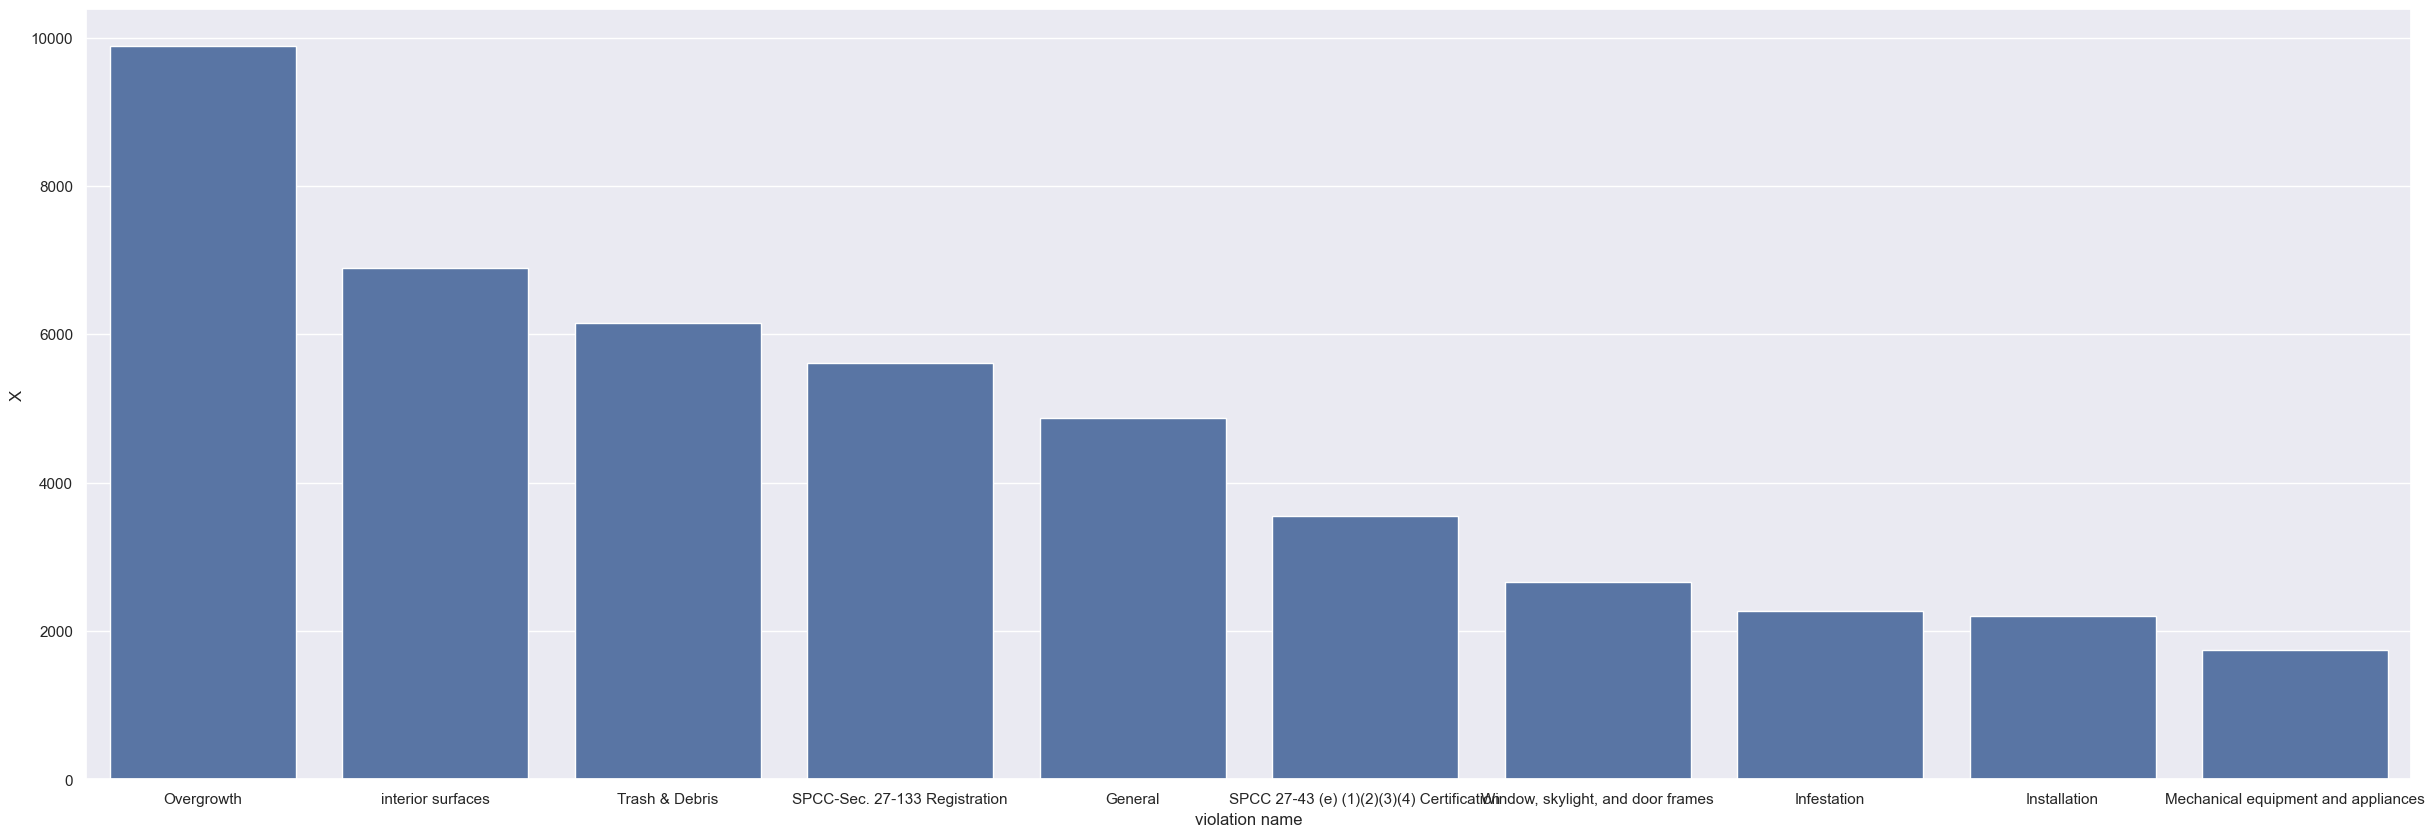

In [22]:
# 90% of the counts of violations are under 200 cases through about 5 years, what about the most frequent ones?
top10_frequent_violations=violation_counts[violation_counts['X']>200].head(10)
sns.set(rc={'figure.figsize':(30, 10)})
sns.barplot(x='violation name',y='X',data=top10_frequent_violations)
# we could generate a simple version of this 'violation' column, excluding information not so useful like 'SPCC - ' etc.

<font size=4># 3. What are the complaint types and how frequent is each type?</font>

In [25]:
complaint_counts=code_violations.groupby('complaint_type_name')['X'].count().to_frame().sort_values(by=['X'],ascending=False)
complaint_counts=complaint_counts.reset_index()
complaint_counts.describe(percentiles=[.25,.75,.90])

,X
count,43.000000
mean,2288.395349
std,6358.091905
min,1.000000
25%,7.500000
50%,95.000000
75%,637.500000
90%,7745.400000
max,35927.000000


<AxesSubplot:xlabel='complaint_type_name', ylabel='X'>

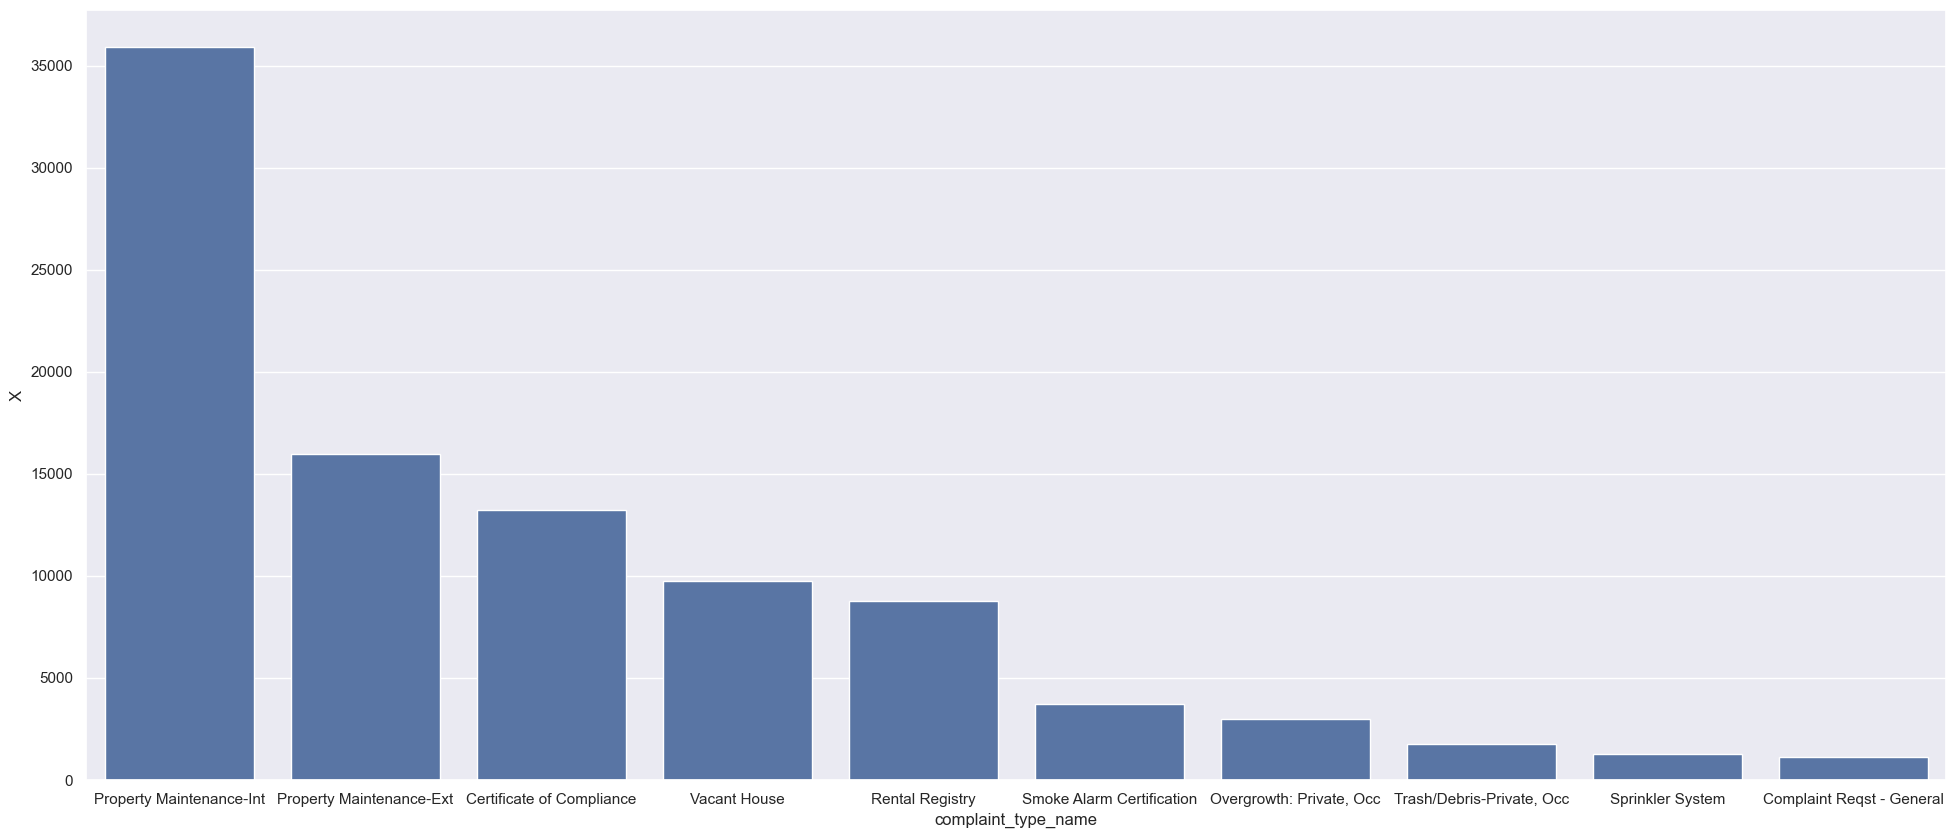

In [24]:
# what about the most frequent complaints?
top10_frequent_complaints=complaint_counts[complaint_counts['X']>200].head(10)
sns.set(rc={'figure.figsize':(24, 10)})
sns.barplot(x='complaint_type_name',y='X',data=top10_frequent_complaints)

<font size=6>Step 3. Answering addressed questions</font>

<font size=4>Question 1. Is there any correlation between neighborhood/location and type of violation?  </font>

<font size=4>1.1. Case numbers within each neighborhood</font>

In [30]:
# 1. Total case number within each neighborhood
total_case_neighborhood=code_violations.groupby('Neighborhood')['violation'].count().to_frame().sort_values('violation',ascending=False)
total_case_neighborhood.columns=['total_case_count']
# 2. Total violation type within each neighborhood
unique_violation_neighborhood=code_violations.groupby('Neighborhood')['violation'].nunique().to_frame().sort_values('violation',ascending=False)
unique_violation_neighborhood.columns=['unique_violation_count']
# 3. Total complaint type within each neighborhood
unique_complaint_neighborhood=code_violations.groupby('Neighborhood')['complaint_type_name'].nunique().to_frame().sort_values('complaint_type_name',ascending=False)
unique_complaint_neighborhood.columns=['unique_complaint_count']
compare_table=pd.concat([total_case_neighborhood,unique_violation_neighborhood,unique_complaint_neighborhood],axis=1)
compare_table

,total_case_count,unique_violation_count,unique_complaint_count
Neighborhood,,,
Northside,15467,406,30
Near Westside,7859,322,29
Brighton,7423,281,21
Washington Square,5503,305,26
Eastwood,5428,314,24
Park Ave,4535,263,19
Elmwood,4513,221,22
Southside,4368,236,20
Southwest,3818,241,21


<font size=4>1.2. The most frequent violation type for each neighborhoods</font>

In [60]:
violation_neighborhood=code_violations.groupby(['Neighborhood','violation name'])['violation'].count().to_frame()
violation_neighborhood.reset_index(inplace=True)
violation_neighborhood_top1=violation_neighborhood.iloc[violation_neighborhood.groupby('Neighborhood')['violation'].idxmax(),0:2].reset_index(drop=True)
violation_neighborhood_top1

,Neighborhood,violation name
0,Brighton,Overgrowth
1,Court-Woodlawn,Overgrowth
2,Downtown,Maintenance of required safeguards
3,Eastwood,Overgrowth
4,Elmwood,Overgrowth
5,Far Westside,SPCC-Sec. 27-133 Registration
6,Franklin Square,SPCC 27-43 (e) (1)(2)(3)(4) Certification
7,Hawley Green,interior surfaces
8,Hawley-Green,General
9,Lakefront,Maintained System


<font size=4>Findings:</font>  
1. The violation case counts for the neighborhoods are different. "Northside" has the most total violation cases associated (15k), which is about 200% of the following neighborhood "near westside".
2. Fot the majority of neighborhoods, the most frequent violation type is "overgrowth", while for some neighborhoods, they have issues concerning "certification", "registration" and "interior surfaces". Not like others, that for downtown neighborhood is "Maintenance of required safeguards".

<font size=4>Question 2. Are the building owners generally local? Are any of them repeat offenders?</font>

<font size=4>2.1. Zip code distribution of owners</font>

In [166]:
owner_zip=code_violations.groupby(['owner_name','owner_zip_code']).size().reset_index()
owner_zip.columns=['owner_name','owner_zip_code','violation_case_count']
owner_zip.sort_values('violation_case_count',inplace=True,ascending=False)
owner_zip['violation_case_count'].describe(percentiles=[.25,.75,.90,.99])

count    10272.000000
mean         9.511001
std         28.396806
min          1.000000
25%          1.000000
50%          3.000000
75%          9.000000
90%         21.000000
99%         93.290000
max       1597.000000
Name: violation_case_count, dtype: float64

In [171]:
# create a list of zip codes in Syracuse
Syracuse_zip_list=range(13201,13226)
remove_list=[13213,13216,13222,13223]
Syracuse_zip_list=np.delete(Syracuse_zip_list, [Syracuse_zip_list.index(x) for x in remove_list])
addition=np.array([13235,13244,13250,13251,13252,13261,13290])
Syracuse_zip_list=np.append(Syracuse_zip_list,addition)
Syracuse_zip_list=Syracuse_zip_list.astype(str)
Syracuse_zip_list

array(['13201', '13202', '13203', '13204', '13205', '13206', '13207',
       '13208', '13209', '13210', '13211', '13212', '13214', '13215',
       '13217', '13218', '13219', '13220', '13221', '13224', '13225',
       '13235', '13244', '13250', '13251', '13252', '13261', '13290'],
      dtype='<U21')

In [175]:
owner_top10_counts=owner_zip.head(10)
local_top10=owner_top10_counts.loc[owner_top10_counts['owner_zip_code'].isin(Syracuse_zip_list),:]
alien_top10=owner_top10_counts.loc[owner_top10_counts['owner_zip_code'].isin(Syracuse_zip_list)==0,:]
owner_top10_counts

,owner_name,owner_zip_code,violation_case_count
3571,GSPDC,13202,1597
10085,William D'Angelo,13088,616
7319,Otto Apartments LLC,60602,544
4214,Infisium Property Management,13120,515
1231,Ballantyne Garden Apt Syr LLC,11219,489
1232,Ballantyne Gardens Apts/Jackie,13205,489
4202,Infisium Properties,13206,444
9147,Syr Model Nbhrd Corp,13205,438
7274,Onondaga Hilltop Homes Inc,10022,394
4767,Jerry Murphy,13104,352


In [177]:
print([local_top10.shape[0],local_top10['violation_case_count'].sum()])
print([alien_top10.shape[0],alien_top10['violation_case_count'].sum()])

[4, 2968]
[6, 2910]


<font size=4>2.2. Local vs. alien owners</font>

In [164]:
local_owner=owner_zip.loc[owner_zip['owner_zip_code'].isin(Syracuse_zip_list),:]
[local_owner.shape[0],local_owner['violation_case_count'].sum()]

[7007, 51506]

In [165]:
alien_owner=owner_zip.loc[owner_zip['owner_zip_code'].isin(Syracuse_zip_list)==0,:]
[alien_owner.shape[0],alien_owner['violation_case_count'].sum()]

[3265, 46191]

<font size=4>Findings:</font>  
1. The majority (99%) of owners listed in the violation records are associated with less than about 93 records. Among the top 10 most frequent seen owners, most of them are companies while there is one owner seems an individual.
2. Among the unique owners list, about 70% of them are local owners, which contribute about 50k violation records, while the left 30% of owners are aliens but contribute about 46k violation records. Based on the information, local owners are less likely to offend the regulations.

<font size=4>Question 3. How did COVID impact the number of housing violations (if at all)? </font>

<font size=4>3.1. Covid outbreak</font>  
Timeline information source: https://www.cdc.gov/museum/timeline/covid19.html  
  
Based on the information provided by CDC (Centers for Disease Control and Prevention) in US, "After more than 118,000 cases in 114 countries and 4,291 deaths,the WHO declares COVID-19 a pandemic" on March 11, 2020  
  
Soon on March 13, 2020, "The Trump Administration declares a nationwide emergency and issues an additional travel ban on non-U.S. citizens traveling from 26 European countries due to COVID-19."

In [233]:
monthly_sum=code_violations.resample('M',on='violation_date')['violation'].count().to_frame().reset_index()
monthly_sum.head()

,violation_date,violation
0,2018-12-31,95
1,2019-01-31,668
2,2019-02-28,415
3,2019-03-31,781
4,2019-04-30,1070


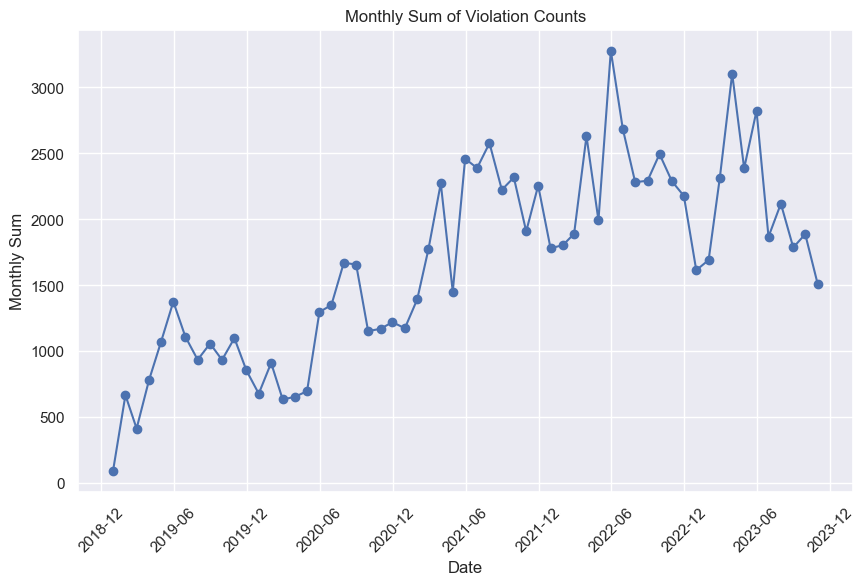

In [239]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(monthly_sum['violation_date'], monthly_sum['violation'], marker='o', linestyle='-', color='b')
plt.title('Monthly Sum of Violation Counts')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Monthly Sum')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.grid(True)
plt.show()

Based on the plot, I cannot conclude there are influences on violation counts from Covid due to the lack of information before 2019.